# Day 9 Analysis

Day 9 is a continuation of Day 8's analysis of WR target share vs. fantasy points for the 2022 season through Week 8. This analysis will focus on expected fanatsy points (standard scoring) given a player's average target share. To calculate expected fanatsy points scored a regression line was fit on data from 1999-2021 and then that was used on 2021 data.

I'll do some exploratory analysis on expected fanatsy points scored and the difference between a player's actual fantasy points and expected fanatsy points which I will call average points differential or `avg_points_diff`. I want to see the probability of a player with X point differential to see how likely that player is to regress positively or negatively towards his expected points.

A positive regression candidate is a "buy low" player and a negative regression candidate is a "sell high" player.

## Set Up

In [165]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create database connection
conn = sqlite3.connect('../data/db/database.db')

## Target Share vs. Fantasy Points: 1999-2011
First I'll get the average target share and fanatsy points scored by WR for seasons 1999-2021. Then I'll fit a regression line to the data which will be used to generate expected fanatsy points for the 2022 season.

### Get Data

In [222]:
query = """
WITH data AS (
    SELECT
        player_id,
        player_display_name AS player_name,
        target_share AS tgt_share,
        fantasy_points AS fantasy_pts
    FROM weekly 
    WHERE position = 'WR'
        AND season_type = 'REG'
        AND target_share IS NOT NULL -- There are data errors where target share was recorded as NULL, these can be removed
        AND season <> 2022
), aggregation AS (
    SELECT
        player_name,
        COUNT(*) AS num_games,
        AVG(tgt_share) AS avg_tgt_share,
        AVG(fantasy_pts) AS avg_fantasy_pts
    FROM data
    GROUP BY player_id, player_name
)
SELECT *
FROM aggregation
"""

df_by_player_1999_2021 = pd.read_sql(query, conn)
print(df_by_player_1999_2021.shape)
df_by_player_1999_2021.head()


(1170, 4)


,player_name,num_games,avg_tgt_share,avg_fantasy_pts
0,Derrick Alexander,52,0.199942,7.315385
1,Brian Alford,2,0.057958,3.350000
2,Reidel Anthony,36,0.121562,2.800000
3,Justin Armour,14,0.173866,5.014286
4,Karsten Bailey,9,0.076829,1.644444


### Clean Data

In [216]:
# Check for number of games played
# If number of game played = 1, can create noise. Will want to remove
print(df_by_player_1999_2021['num_games'].value_counts(normalize=True).sort_index()[:4].sum())
df_by_player_1999_2021['num_games'].value_counts(normalize=True).sort_index()[:10]

0.23333333333333334


1     0.096581
2     0.058974
3     0.045299
4     0.032479
5     0.025641
6     0.021368
7     0.029915
8     0.024786
9     0.015385
10    0.013675
Name: num_games, dtype: float64

I'll remove players with only 1 game played since those can definitely create some noise in the data. Based on normalized values I'd like to take players that have at least 5 games played but that would mean removing almost 25% of the data so I'll leave players with 2+ games in the dataset.

In [217]:
df_by_player_1999_2021 = df_by_player_1999_2021[df_by_player_1999_2021['num_games'] > 1]
print(df_by_player_1999_2021.shape)

(1057, 5)


### Exploratory Analysis

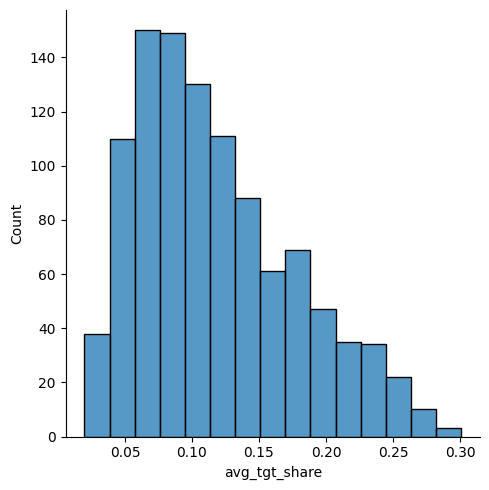

In [218]:
# Check distribution
sns.displot(
    x="avg_tgt_share",
    data=df_by_player_1999_2021,
    kind="hist",
    bins = 15
)

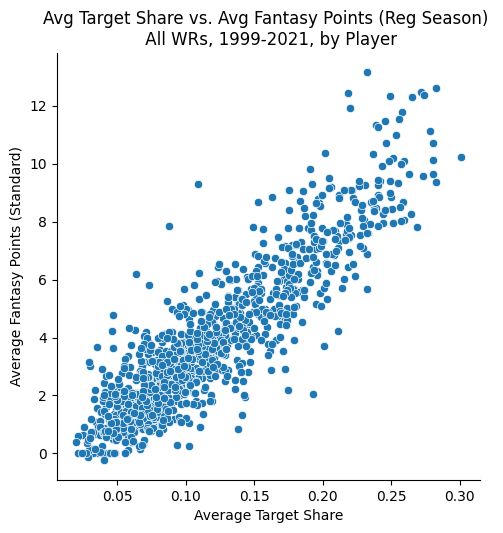

In [219]:
g = sns.relplot(
    x="avg_tgt_share",
    y="avg_fantasy_pts",
    data=df_by_player_1999_2021
)

g.set(
    xlabel="Average Target Share", 
    ylabel="Average Fantasy Points (Standard)",
    title="Avg Target Share vs. Avg Fantasy Points (Reg Season) \n All WRs, 1999-2021, by Player"
)

In [220]:
print(f"Correlation Coefficient: {df_by_player_1999_2021['avg_tgt_share'].corr(df_by_player_1999_2021['avg_fantasy_pts'])}")

Correlation Coefficient: 0.8935066509956594


### Run Regression

In [221]:
# # Drop null values
# df_avg_final = df_avg_final.dropna(subset=['avg_tgt_share', 'avg_fantasy_pts'])

# Fit a regression line
fit = np.polyfit(
    x=df_by_player_1999_2021['avg_tgt_share'], 
    y=df_by_player_1999_2021['avg_fantasy_pts'], 
    deg=1)

lin_func_fpts = np.poly1d(fit)

In [250]:
# Use regression equation to get expected fantasy points for the 2022 season

# Get data
query = """
WITH data AS (
    SELECT
        player_id,
        player_display_name AS player_name,
        target_share AS tgt_share,
        fantasy_points AS fantasy_pts
    FROM weekly 
    WHERE position = 'WR'
        AND season_type = 'REG'
        AND target_share IS NOT NULL -- There are data errors where target share was recorded as NULL, these can be removed
        AND season = 2022
), aggregation AS (
    SELECT
        player_name,
        COUNT(*) AS num_games,
        AVG(tgt_share) AS avg_tgt_share,
        AVG(fantasy_pts) AS avg_fantasy_pts
    FROM data
    GROUP BY player_id, player_name
)
SELECT *
FROM aggregation
"""

df_by_player_2022 = pd.read_sql(query, conn)

# Create summary table
summary_2022 = df_by_player_2022.sort_values('avg_fantasy_pts', ascending=False).reset_index(drop=True) # index = fantasy points ranking
summary_2022.index = summary_2022.index + 1 # easier to read (1 is now top player by avg fantasy points)

summary_2022 = summary_2022.sort_values('avg_tgt_share', ascending=False)

summary_2022['avg_pts_expected'] = lin_func_fpts(summary_2022['avg_tgt_share'])
summary_2022['avg_pts_diff'] = summary_2022['avg_fantasy_pts'] - summary_2022['avg_pts_expected']

print(summary_2022.shape)
summary_2022.head(10).round(3)


(196, 6)


,player_name,num_games,avg_tgt_share,avg_fantasy_pts,avg_pts_expected,avg_pts_diff
2,DeAndre Hopkins,2,0.393,16.100,14.569,1.531
25,CeeDee Lamb,8,0.328,9.350,12.050,-2.700
3,Cooper Kupp,7,0.325,15.386,11.930,3.456
4,Tyreek Hill,8,0.321,13.825,11.802,2.023
6,A.J. Brown,7,0.318,13.700,11.683,2.017
10,Davante Adams,7,0.297,11.586,10.837,0.749
33,D.J. Moore,8,0.290,8.050,10.598,-2.548
5,Justin Jefferson,7,0.290,13.774,10.593,3.181
1,Stefon Diggs,7,0.287,16.914,10.481,6.433
55,Drake London,8,0.280,6.075,10.205,-4.130


Based on the regression line fit on 1999-2021, CeeDee Lamb is scoring 2.7 standard fantasy points less than he should be, per week – a good candidate for positive regression given his extremely high target share. Stefon Diggs is scoring 6.4 standard fantasy points more than he should be, per week – a good candidate for negative regression. He is scoring much more than would be expected given his target share.

To see how likely it is for a player to regress to the mean, I will look at the distribution of `avg_points_diff` and if normal, will use statistical methods to determine probability.

In [251]:
# Sort by the difference between actual points and expected points to get the true "regression to the mean" candidates
# Remove players with only 1 game played as that can be considered noise
summary_2022[summary_2022['num_games'] > 1] \
    .sort_values('avg_pts_diff') \
    .head(10) \
    .round(3)

,player_name,num_games,avg_tgt_share,avg_fantasy_pts,avg_pts_expected,avg_pts_diff
83,Darnell Mooney,8,0.273,4.550,9.929,-5.379
69,Diontae Johnson,8,0.265,5.175,9.598,-4.423
55,Drake London,8,0.280,6.075,10.205,-4.130
84,Robert Woods,7,0.231,4.514,8.282,-3.768
103,Equanimeous St. Brown,7,0.196,3.557,6.936,-3.379
147,Marcus Johnson,4,0.143,1.575,4.866,-3.291
42,Sterling Shepard,3,0.272,7.133,9.874,-2.740
25,CeeDee Lamb,8,0.328,9.350,12.050,-2.700
96,Michael Gallup,5,0.186,3.900,6.519,-2.619
33,D.J. Moore,8,0.290,8.050,10.598,-2.548


Darnell Mooney is the standout here. With almost 27% of his team's target share in 2022 he's scoring about 5.3 standard fantasy points less per game than he "should be" based on the observed relationship between target share and fantasy points. 

## Analyze Average Points Differential

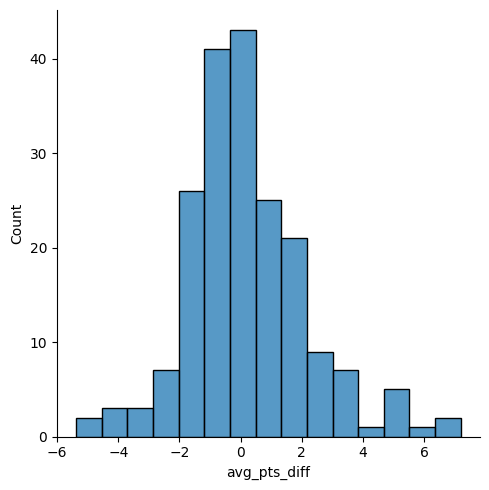

In [252]:
sns.displot(
    x='avg_pts_diff',
    data=summary_2022,
    kind="hist",
    bins=15
)

The distribution looks like a normal distribution with mean around 0. Next I'll get average points differential on the 1999-2021 population to confirm.

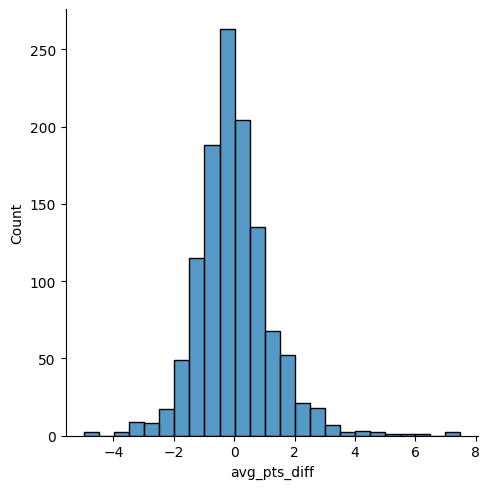

In [253]:
# Use regression line on original dataset with all values 
df_by_player_1999_2021['avg_pts_expected'] = lin_func_fpts(df_by_player_1999_2021['avg_tgt_share'])
df_by_player_1999_2021['avg_pts_diff'] = df_by_player_1999_2021['avg_fantasy_pts'] - df_by_player_1999_2021['avg_pts_expected']

sns.displot(
    x='avg_pts_diff',
    data=df_by_player_1999_2021,
    kind="hist",
    bins=25
)

The population distribution confirms that average points differential is normally distributed with a mean of approximately 0.

In [254]:
summary_2022['avg_pts_diff'].describe()

count    196.000000
mean       0.195047
std        1.994799
min       -5.379261
25%       -0.965766
50%       -0.124061
75%        1.287674
max        7.202937
Name: avg_pts_diff, dtype: float64

In [255]:
df_by_player_1999_2021['avg_pts_diff'].describe().apply(lambda x: format(x, 'f'))

count    1170.000000
mean       -0.029546
std         1.224658
min        -4.962556
25%        -0.702053
50%        -0.128819
75%         0.568711
max         7.469924
Name: avg_pts_diff, dtype: object

The observed expected points differential from 1999-2021 is normally distributed with a mean of 0 and standard deviation of 1.122. Therefore we would expect the sample population of player averages for 2022 to be normally distributed as well and thus we should be able to compute the likelihood of a player finishing with that expected point differential (actual - expected) using statistical methods. 

In [264]:
import scipy.stats

def cdf_player_2022(df, player_name):
    cdf = scipy.stats.norm(
            df['avg_pts_diff'].mean(),
            df['avg_pts_diff'].std()
            ).cdf(df[df['player_name'] == player_name]['avg_pts_diff'])
    return round((cdf[0] * 100),2)

def pdf_player_2022(df, player_name):
    pdf = scipy.stats.norm(
            df['avg_pts_diff'].mean(),
            df['avg_pts_diff'].std()
            ).pdf(df[df['player_name'] == player_name]['avg_pts_diff'])
    return round((pdf[0] * 100),2)

The pdf function calculates the probability of X for a given value of X. In this case, we are looking at the probability of a player having an average points differential of X for a given value of X (target share).

In [265]:
pdf_player_2022(summary_2022, 'CeeDee Lamb')

6.98

Going back to CeeDee lamb, using the normal distribution of average points differential, we are able to calculate that there is a 7% chance of scoring 2.7 points less than expected per week given his nearly 33% target share. If this is the case, CeeDee is a great "buy low", positive regression candidate and should be due for a more productive second half of the season.